Epoch [1/300], Train Loss: 4.2539, Train Accuracy: 2.03%, Validation Loss: 4.1015, Validation Accuracy: 4.24%
Epoch [2/300], Train Loss: 4.1169, Train Accuracy: 3.23%, Validation Loss: 3.9922, Validation Accuracy: 4.97%
Epoch [3/300], Train Loss: 4.0538, Train Accuracy: 4.60%, Validation Loss: 3.9548, Validation Accuracy: 7.60%
Epoch [4/300], Train Loss: 3.9760, Train Accuracy: 6.17%, Validation Loss: 3.8567, Validation Accuracy: 10.82%
Epoch [5/300], Train Loss: 3.9258, Train Accuracy: 7.54%, Validation Loss: 3.8161, Validation Accuracy: 10.09%
Epoch [6/300], Train Loss: 3.8690, Train Accuracy: 8.56%, Validation Loss: 3.7536, Validation Accuracy: 10.53%
Epoch [7/300], Train Loss: 3.8136, Train Accuracy: 9.29%, Validation Loss: 3.6988, Validation Accuracy: 11.70%
Epoch [8/300], Train Loss: 3.7585, Train Accuracy: 11.07%, Validation Loss: 3.6302, Validation Accuracy: 14.04%
Epoch [9/300], Train Loss: 3.7105, Train Accuracy: 12.02%, Validation Loss: 3.5770, Validation Accuracy: 15.50%
Ep

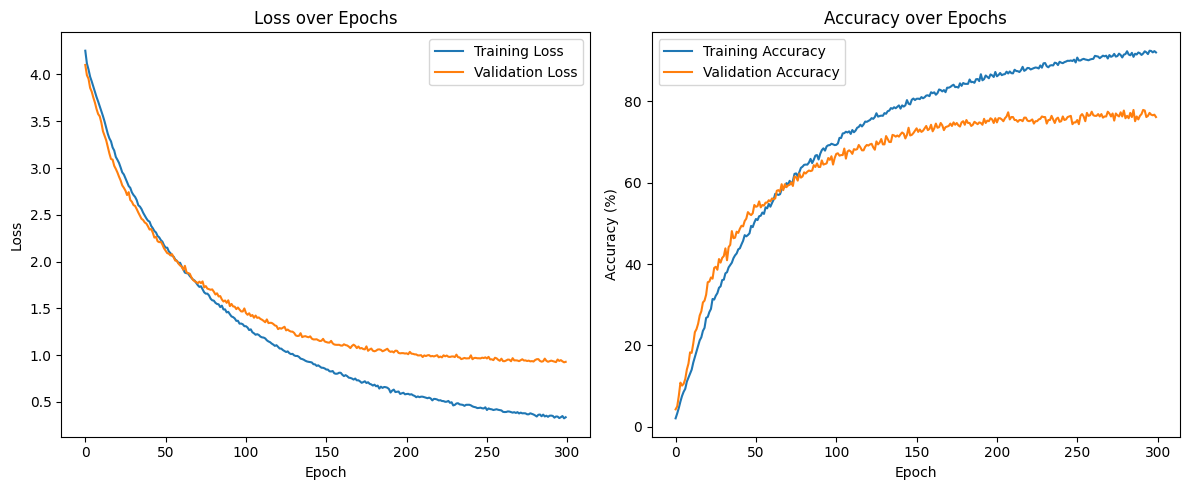

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time


# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self, num_classes=65):  # Set num_classes to 65 
        super(CNNModel, self).__init__()
        self.num_classes=num_classes
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=1)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3)
        self.conv6 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=1)
        self.conv7 = nn.Conv2d(128, 128, kernel_size=2)  # Reduced kernel size to 2x2
        self.batch_norm = nn.BatchNorm2d(128)
        self.dropout = nn.Dropout(0.5)

        # Calculate the input size for the fully connected layer dynamically
        self.fc1=None
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.dropout(x)
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.dropout(x)
        x = F.relu(self.conv7(x))
        x = self.batch_norm(x)

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Dynamically define the fully connected layer based on the input size
        if self.fc1 is None:
            self.fc1 = nn.Linear(x.size(1), self.num_classes)
            self.fc1 = self.fc1.to(x.device)

        x = self.dropout(x)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)





# Rest of the training code remains unchanged

# Data paths
train_data_dir = 'dataset'  # Update this with your dataset path
batch_size = 64
img_size = 28

# Define data transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize
])

# Load the dataset
train_dataset = datasets.ImageFolder(train_data_dir, transform=transform)

# Split the data into train and validation
train_size = int(0.9 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Instantiate the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel(num_classes=65).to(device)  # 65 classes for Nepal Bhasa characters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Lists to store loss and accuracy values
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

# Training loop
num_epochs = 300
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation loop
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valid_loss = valid_loss / len(valid_loader)
    valid_acc = 100 * correct / total
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, "
          f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.2f}%")
# End timing
end_time = time.time()
training_time = (end_time - start_time)/60

print(f"Total training time: {training_time:.2f} minutes")
# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Save the model after training
torch.save(model.state_dict(), 'nepal_bhasa_cnn_newLR0.0001.pth')


In [37]:
torch.save(model.state_dict(), 'nepal_bhasa_cnn_newLR0.0001.pth')

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import tkinter as tk
from tkinter import filedialog

# CNN Model Definition (same as used during training)
class CNNModel(nn.Module):
    def __init__(self, num_classes=65):  # Set num_classes to 65 for Nepal Bhasa characters
        super(CNNModel, self).__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=1)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3)
        self.conv6 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=1)
        self.conv7 = nn.Conv2d(128, 128, kernel_size=2)  # Reduced kernel size to 2x2
        self.batch_norm = nn.BatchNorm2d(128)
        
        self.dropout = nn.Dropout(0.5)
        # Define the fully connected layer in the constructor
        self.fc1 = nn.Linear(128 * 15 * 15, self.num_classes)
        # self.fc1=None

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.dropout(x)
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.dropout(x)
        x = F.relu(self.conv7(x))
        x = self.batch_norm(x)

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # if self.fc1 is None:
        #     self.fc1 = nn.Linear(x.size(1), self.num_classes).to(x.device)

        x = self.dropout(x)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel(num_classes=65)
model.load_state_dict(torch.load('nepal_bhasa_cnn_newLR0.0001.pth', map_location=device))
model.eval()
model.to(device)

# Define the transform (same as used during training)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure grayscale
    transforms.Resize((28, 28)),  # Resize to the same size used during training
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize
])

# Function to make a prediction
def predict_image(image_path):
    # Load the image
    image = Image.open(image_path)
    
    # Apply the transformations
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Make prediction
    with torch.no_grad():
        output = model(image)
        predicted_class = torch.argmax(output, dim=1).item()

    return predicted_class

# Function to upload and predict image+
def upload_and_predict():
    # Open file dialog to select image
    root = tk.Tk()
    root.withdraw()  # Hide the main tkinter window
    image_path = filedialog.askopenfilename()  # Open file dialog
    if image_path:
        predicted_class = predict_image(image_path)
        print(f'Predicted Class: {predicted_class}')
    else:
        print("No image selected.")

# Run the image upload and prediction
upload_and_predict()


Predicted Class: 63


In [ ]:
11:23
2:10